In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("FirmLevel_PanelData_10K.csv")

In [2]:
# Convert to categorical
df["FirmID"] = df["FirmID"].astype("category")
df["Year"] = df["Year"].astype("category")

# Create lag variable
df["Profitability_Lag1"] = df.groupby("FirmID")["Profitability"].shift(1)
df.dropna(inplace=True)

In [3]:
# ------------------------------
# Step 2: Fixed Effects - LSDV (Least Squares Dummy Variables)
# ------------------------------
# The LSDV approach includes a dummy variable for each firm.
# This controls for unobserved time-invariant firm characteristics.
# It estimates the within-firm effects by isolating variation over time.
model_lsdv = smf.ols("Profitability ~ RND_Expenses + Advertising_Spends + Debt_Equity_Ratio + Firm_Size + C(FirmID)",
                     data=df).fit()

In [4]:
#print("\nLSDV Fixed Effects Summary:\n", model_lsdv.summary())

/Users/varunnkaushik/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



✅ LSDV Model Performance on 2019 Test Set
RMSE: 0.539
R² Score: 0.449


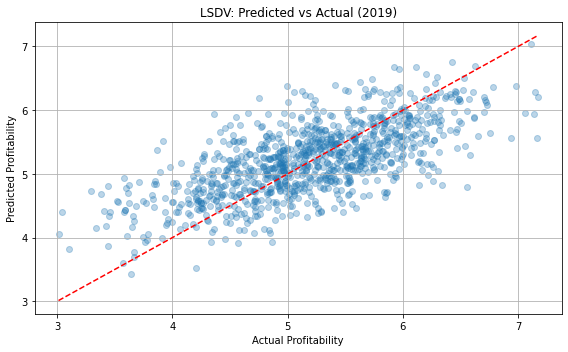

In [5]:
# ------------------------------
# Step 2A: Out-of-Sample Validation (LSDV)
# ------------------------------
# Create train-test split based on time

# Ensure 'Year' is numeric
df["Year"] = df["Year"].astype(int)
train_df = df[df["Year"] <= 2018]
test_df = df[df["Year"] == 2019]


# Fit LSDV model on training data
formula = "Profitability ~ RND_Expenses + Advertising_Spends + Debt_Equity_Ratio + Firm_Size + C(FirmID)"
model_lsdv = smf.ols(formula=formula, data=train_df).fit()

# Filter test set to retain only firms seen during training
known_firms = train_df["FirmID"].unique()
excluded_firms = test_df.loc[~test_df["FirmID"].isin(known_firms), "FirmID"].unique()
if len(excluded_firms) > 0:
    print("⚠️ Firms dropped from test set (not seen in training):", list(excluded_firms))
test_df = test_df[test_df["FirmID"].isin(known_firms)]

# Predict and evaluate
y_true = test_df["Profitability"]
y_pred = model_lsdv.predict(test_df)

rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print("\n✅ LSDV Model Performance on 2019 Test Set")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Profitability")
plt.ylabel("Predicted Profitability")
plt.title("LSDV: Predicted vs Actual (2019)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# ------------------------------
# Step 3: Fixed Effects - Within Estimator (Demeaning Approach)
# ------------------------------
# This manually removes firm-specific effects by demeaning each variable.
# It estimates the effect of changes within each firm over time.
df_within = df.copy()
df_within["Profitability_demeaned"] = df_within.groupby("FirmID")["Profitability"].transform(lambda x: x - x.mean())
for col in ["RND_Expenses", "Advertising_Spends", "Debt_Equity_Ratio", "Firm_Size"]:
    df_within[col + "_dm"] = df_within[col] - df_within.groupby("FirmID")[col].transform("mean")

X_within = sm.add_constant(df_within[[col + "_dm" for col in ["RND_Expenses", "Advertising_Spends", "Debt_Equity_Ratio", "Firm_Size"]]])
model_within = sm.OLS(df_within["Profitability_demeaned"], X_within).fit()
print("\nWithin Estimator Summary:\n", model_within.summary())


Within Estimator Summary:
                               OLS Regression Results                              
Dep. Variable:     Profitability_demeaned   R-squared:                       0.079
Model:                                OLS   Adj. R-squared:                  0.078
Method:                     Least Squares   F-statistic:                     192.4
Date:                    Fri, 30 May 2025   Prob (F-statistic):          1.53e-158
Time:                            00:00:10   Log-Likelihood:                -6096.2
No. Observations:                    9000   AIC:                         1.220e+04
Df Residuals:                        8995   BIC:                         1.224e+04
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

/Users/varunnkaushik/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



✅ Within Estimator Model Performance on 2019 Test Set
RMSE: 0.534
R² Score: 0.052


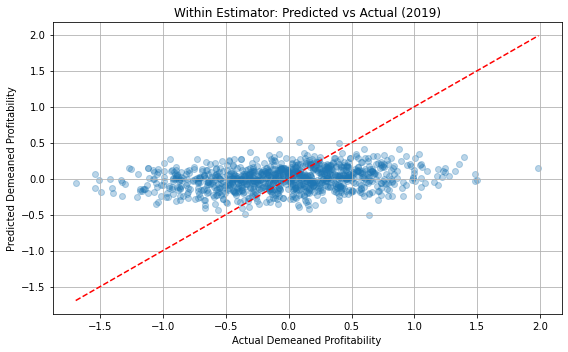

In [9]:
# ------------------------------
# Step 3A: Out-of-Sample Validation (Within Estimator)
# ------------------------------
df_val = df.copy()

# Split data into training and test sets
train_within = df_val[df_val["Year"] <= 2018].copy()
test_within = df_val[df_val["Year"] == 2019].copy()

# Calculate firm means from the TRAINING data ONLY
# This is crucial: we use the means from the data the model "learns" from
firm_means = train_within.groupby("FirmID")[["Profitability", "RND_Expenses", "Advertising_Spends", "Debt_Equity_Ratio", "Firm_Size"]].mean()

# Ensure FirmID data types are consistent for mapping
# Convert FirmID in both train_within and test_within to the same type as firm_means index
train_within["FirmID"] = train_within["FirmID"].astype(firm_means.index.dtype)
test_within["FirmID"] = test_within["FirmID"].astype(firm_means.index.dtype)

# Demean TRAINING data
# Apply demeaning to the training data using the firm means calculated from training data
for col in ["Profitability", "RND_Expenses", "Advertising_Spends", "Debt_Equity_Ratio", "Firm_Size"]:
    train_within[col + "_dm"] = train_within[col] - train_within["FirmID"].map(firm_means[col])

# Prepare training data for the OLS model
X_train = sm.add_constant(train_within[[col + "_dm" for col in ["RND_Expenses", "Advertising_Spends", "Debt_Equity_Ratio", "Firm_Size"]]])
y_train = train_within["Profitability_dm"]

# Fit the Within Estimator model on demeaned training data
model_within_val = sm.OLS(y_train, X_train).fit()


# Demean TEST data using the SAME firm means from the TRAINING data
# This ensures consistency: the test data is transformed based on the training data's characteristics
for col in ["Profitability", "RND_Expenses", "Advertising_Spends", "Debt_Equity_Ratio", "Firm_Size"]:
    test_within[col + "_dm"] = test_within[col] - test_within["FirmID"].map(firm_means[col])

# Prepare test data for prediction
X_test = sm.add_constant(test_within[[col + "_dm" for col in ["RND_Expenses", "Advertising_Spends", "Debt_Equity_Ratio", "Firm_Size"]]])
y_test = test_within["Profitability_dm"]

# Make predictions on the demeaned test set
y_pred_test = model_within_val.predict(X_test)

# Calculate performance metrics
rmse_w = mean_squared_error(y_test, y_pred_test, squared=False)
r2_w = r2_score(y_test, y_pred_test)

print("\n✅ Within Estimator Model Performance on 2019 Test Set")
print(f"RMSE: {rmse_w:.3f}")
print(f"R² Score: {r2_w:.3f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Demeaned Profitability")
plt.ylabel("Predicted Demeaned Profitability")
plt.title("Within Estimator: Predicted vs Actual (2019)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# ------------------------------
# Step 4: Two-Way Fixed Effects (Firm + Year Effects)
# ------------------------------
model_twfe = smf.ols(
    "Profitability ~ RND_Expenses + Advertising_Spends + Debt_Equity_Ratio + Firm_Size + C(FirmID) + C(Year)",
    data=df,
).fit()
print("\nTwo-Way Fixed Effects Summary:\n", model_twfe.summary())


Two-Way Fixed Effects Summary:
                             OLS Regression Results                            
Dep. Variable:          Profitability   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     11.86
Date:                Fri, 30 May 2025   Prob (F-statistic):               0.00
Time:                        00:00:54   Log-Likelihood:                -6828.1
No. Observations:               10000   AIC:                         1.568e+04
Df Residuals:                    8987   BIC:                         2.299e+04
Df Model:                        1012                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Int

In [11]:
# ------------------------------
# Step 5: First Difference Estimator (FD)
# ------------------------------
# This approach uses the change (difference) in variables across time.
# It removes fixed effects by differencing successive observations for each firm.
df_fd = df.sort_values(["FirmID", "Year"]).copy()
df_fd_numeric = df_fd.drop(columns=["FirmID", "Year", "Sector"])
df_fd_diff = df_fd_numeric.groupby(df_fd["FirmID"]).diff().dropna()

model_fd = sm.OLS(
    df_fd_diff["Profitability"],
    sm.add_constant(df_fd_diff[["RND_Expenses", "Advertising_Spends", "Debt_Equity_Ratio", "Firm_Size"]])
).fit()
print("\nFirst Difference Estimator Summary:\n", model_fd.summary())


First Difference Estimator Summary:
                             OLS Regression Results                            
Dep. Variable:          Profitability   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     210.5
Date:                Fri, 30 May 2025   Prob (F-statistic):          6.74e-173
Time:                        00:00:58   Log-Likelihood:                -9765.7
No. Observations:                9000   AIC:                         1.954e+04
Df Residuals:                    8995   BIC:                         1.958e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [12]:
# ------------------------------
# Step 6: Between Estimator
# ------------------------------
# This model uses variation between firms by taking the firm-level means.
# It ignores within-firm variation and is more like a cross-sectional estimator.
df_between = df.groupby("FirmID")[
    ["Profitability", "RND_Expenses", "Advertising_Spends", "Debt_Equity_Ratio", "Firm_Size"]
].mean().reset_index()

model_between = sm.OLS(
    df_between["Profitability"],
    sm.add_constant(df_between[["RND_Expenses", "Advertising_Spends", "Debt_Equity_Ratio", "Firm_Size"]])
).fit()
print("\nBetween Estimator Summary:\n", model_between.summary())


Between Estimator Summary:
                             OLS Regression Results                            
Dep. Variable:          Profitability   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     307.8
Date:                Fri, 30 May 2025   Prob (F-statistic):          2.86e-172
Time:                        00:01:02   Log-Likelihood:                -389.57
No. Observations:                1000   AIC:                             789.1
Df Residuals:                     995   BIC:                             813.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const  